In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import jax
import jax.numpy as jnp
from time import perf_counter
from diffrax import ODETerm, SaveAt, Tsit5, diffeqsolve
import matplotlib.pyplot as plt

# Planar PCS

In [3]:
from soromox.systems.tendon_actuated_planar_pcs import TendonActuatedPlanarPCS
from models.simplified_tendon_actuated_planar_pcs import SimplifiedTendonActuatedPlanarPCS

In [4]:
num_segments = 2  # number of segments in the robot
params = {
    "th0": jnp.array(jnp.pi / 2),  # initial orientation angle [rad]
    "L": 1e-1 * jnp.ones((num_segments,)),
    "r": 2e-2 * jnp.ones((num_segments,)),
    "rho": 1070 * jnp.ones((num_segments,)),  # Volumetric density of Dragon Skin 20 [kg/m^3]
    "g": jnp.array([0.0, 9.81]),  # gravitational acceleration [m/s^2] UP!
    "E": 5e3 * jnp.ones((num_segments,)),  # Elastic modulus [Pa]
    "G": 1e3 * jnp.ones((num_segments,)),  # Shear modulus [Pa]
    "d": 2e-2 * jnp.array([[1.0, -1.0]]).repeat(num_segments, axis=0),  # distance of tendons from the central axis [m]
}
params["D"] = 1e-3 * jnp.diag((jnp.repeat(jnp.array([[1e0, 1e3, 1e3]]), num_segments, axis=0) * params["L"][:, None]).flatten())

strain_selector = jnp.ones((3 * num_segments,), dtype=bool) # activate all strains (i.e. bending, shear, and axial)
segment_actuation_selector = jnp.ones((num_segments,), dtype=bool)  # actuation selector for the segments

full_robot = TendonActuatedPlanarPCS(num_segments=num_segments, params=params, strain_selector=strain_selector, segment_actuation_selector=segment_actuation_selector)
simplified_robot = SimplifiedTendonActuatedPlanarPCS(num_segments=num_segments, params=params, strain_selector=strain_selector, segment_actuation_selector=segment_actuation_selector)

In [5]:
q0 = jax.random.normal(jax.random.PRNGKey(4), shape=int(full_robot.num_active_strains)) * jnp.repeat(jnp.array([5.0 * jnp.pi, 0.1, 0.05])[None, :], num_segments, axis=0).flatten()
qd0 = jnp.zeros_like(q0)
x0 = jnp.concatenate([q0, qd0])
u = jax.random.uniform(jax.random.PRNGKey(0), shape=(full_robot.num_actuators,), minval=-0.5, maxval=0.0)

In [6]:
t_sim = 10.0
dt = 1e-4
saveat = SaveAt(ts=jnp.arange(0.0, t_sim, 1e-2))

full_term = ODETerm(full_robot.forward_dynamics)
tic = perf_counter()
sim_full = diffeqsolve(terms=full_term, solver=Tsit5(), t0=0.0, t1=t_sim, dt0=dt, y0=x0, args=(u,), saveat=saveat, max_steps=None)
simulation_time_full = perf_counter() - tic
print(f"simulation time with full dynamics: {simulation_time_full:.3f} seconds")

simplified_term = ODETerm(simplified_robot.forward_dynamics)
tic = perf_counter()
sim_simplified = diffeqsolve(terms=simplified_term, solver=Tsit5(), t0=0.0, t1=t_sim, dt0=dt, y0=x0, args=(u,), saveat=saveat, max_steps=None)
simulation_time_simplified = perf_counter() - tic
print(f"simulation time with simplified dynamics: {simulation_time_simplified:.3f} seconds")

print("\n")
print(f"The simplified dynamics make the simulation {((simulation_time_full - simulation_time_simplified) / simulation_time_full * 100):.2f}% faster.")

simulation time with full dynamics: 40.818 seconds
simulation time with simplified dynamics: 18.797 seconds


The simplified dynamics make the simulation 53.95% faster.


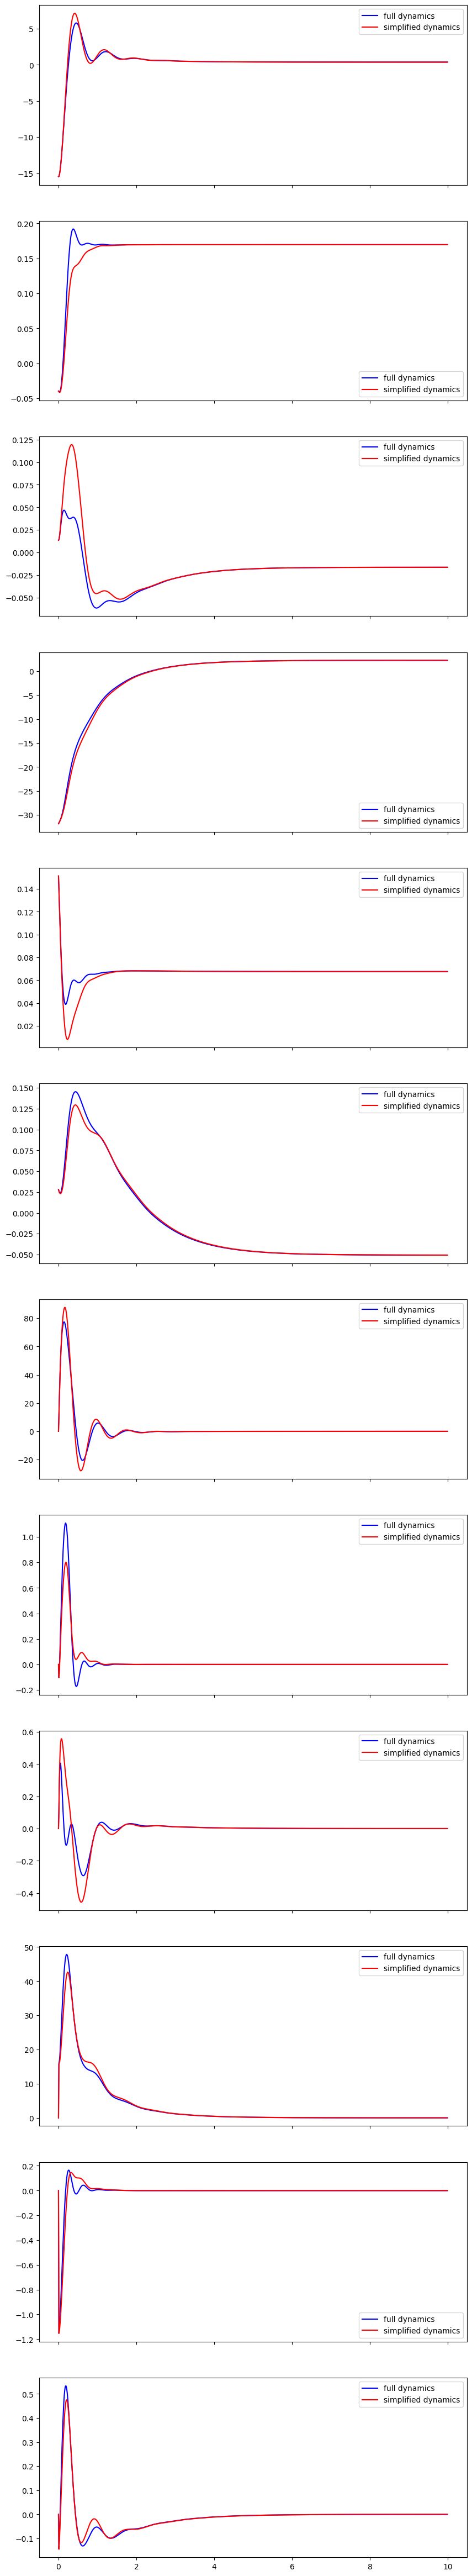

In [7]:
fig, ax = plt.subplots(sim_full.ys.shape[1], 1, figsize=(10, 5*sim_full.ys.shape[1]), sharex=True)
for i in range(sim_full.ys.shape[1]):
    ax[i].plot(sim_full.ts, sim_full.ys[:, i], c='b', label="full dynamics")
    ax[i].plot(sim_simplified.ts, sim_simplified.ys[:, i], c='r', label="simplified dynamics")
    ax[i].legend()
plt.show()

# Spatial PCS

In [8]:
from soromox.systems.tendon_actuated_pcs import TendonActuatedPCS
from models.simplified_tendon_actuated_pcs import SimplifiedTendonActuatedPCS

In [9]:
num_segments = 2  # number of segments in the robot
params = {
    "p0": jnp.array([jnp.pi / 2, jnp.pi / 2, 0.0, 0.0, 0.0, 0.0]),  # Initial position and orientation
    "L": 1e-1 * jnp.ones((num_segments,)),  # default: 1e-1
    "r": 2e-2 * jnp.ones((num_segments,)),  # default: 2e-2
    "rho": 1070 * jnp.ones((num_segments,)),  # Volumetric density of Dragon Skin 20 [kg/m^3]
    "g": jnp.array([0.0, 0.0, 9.81]),  # Gravity vector [m/s^2]
    "E": 2e3 * jnp.ones((num_segments,)),  # Elastic modulus [Pa]
    "G": 1e3 * jnp.ones((num_segments,)),  # Shear modulus [Pa]
}
params["D"] = 1e-3 * jnp.diag((jnp.repeat(jnp.array([[1e0, 1e0, 1e0, 1e3, 1e3, 1e3]]), num_segments, axis=0) * params["L"][:, None]).flatten())
active_tendon_routing_params = {
    "ry": 2e-2 * jnp.array([1.0, -1.0]),  # y-coordinate of the pulling point of the tendons [m]
    "rz": 2e-2 * jnp.array([0.0, 0.0]),  # z-coordinate of the pulling point of the tendons [m]
    "my": jnp.array([0.0, 0.0]),  # slope coefficient in the x-y plane of the tendons [-]
    "mz": jnp.array([0.0, 0.0]),  # slope coefficient in the x-z plane of the tendons [-]
    "idx_seg_att": jnp.array([1, 0]),  # length of the tendons = x-coordinate of the attachment points [m]
}
passive_tendon_routing_params = {
    "ry": 2e-2 * jnp.array([0.0]),  # y-coordinate of the pulling point of the tendons [m]
    "rz": 2e-2 * jnp.array([1.0]),  # z-coordinate of the pulling point of the tendons [m]
    "my": jnp.array([0.0]),  # slope coefficient in the x-y plane of the tendons [-]
    "mz": jnp.array([0.0]),  # slope coefficient in the x-z plane of the tendons [-]
    "idx_seg_att": jnp.array([1]),  # length of the tendons = x-coordinate of the attachment points [m]
}
passive_tendon_params = {
    "k_pt": jnp.array([0.6]),
    "d_pt": jnp.array([0.1]),
    "l_pt0": jnp.array([-0.3]),
}

full_robot = TendonActuatedPCS(num_segments=num_segments, params=params, active_tendon_routing_params=active_tendon_routing_params, passive_tendon_routing_params=passive_tendon_routing_params, passive_tendon_params=passive_tendon_params)
simplified_robot = SimplifiedTendonActuatedPCS(num_segments=num_segments, params=params, active_tendon_routing_params=active_tendon_routing_params, passive_tendon_routing_params=passive_tendon_routing_params, passive_tendon_params=passive_tendon_params)

In [10]:
q0 = jnp.repeat(jnp.array([0.0, 0.0, 5.0 * jnp.pi, 0.1, 0.2, 0.0])[None, :], num_segments, axis=0).flatten()
qd0 = jnp.zeros_like(q0)
x0 = jnp.concatenate([q0, qd0])
u = jnp.array([-0.5, -1.0])

In [11]:
t_sim = 10.0
dt = 1e-4
saveat = SaveAt(ts=jnp.arange(0.0, t_sim, 1e-2))

full_term = ODETerm(full_robot.forward_dynamics)
tic = perf_counter()
sim_full = diffeqsolve(terms=full_term, solver=Tsit5(), t0=0.0, t1=t_sim, dt0=dt, y0=x0, args=(u,), saveat=saveat, max_steps=None)
simulation_time_full = perf_counter() - tic
print(f"simulation time with full dynamics: {simulation_time_full:.3f} seconds")

simplified_term = ODETerm(simplified_robot.forward_dynamics)
tic = perf_counter()
sim_simplified = diffeqsolve(terms=simplified_term, solver=Tsit5(), t0=0.0, t1=t_sim, dt0=dt, y0=x0, args=(u,), saveat=saveat, max_steps=None)
simulation_time_simplified = perf_counter() - tic
print(f"simulation time with simplified dynamics: {simulation_time_simplified:.3f} seconds")

print("\n")
print(f"The simplified dynamics make the simulation {((simulation_time_full - simulation_time_simplified) / simulation_time_full * 100):.2f}% faster.")

simulation time with full dynamics: 185.920 seconds
simulation time with simplified dynamics: 72.964 seconds


The simplified dynamics make the simulation 60.75% faster.


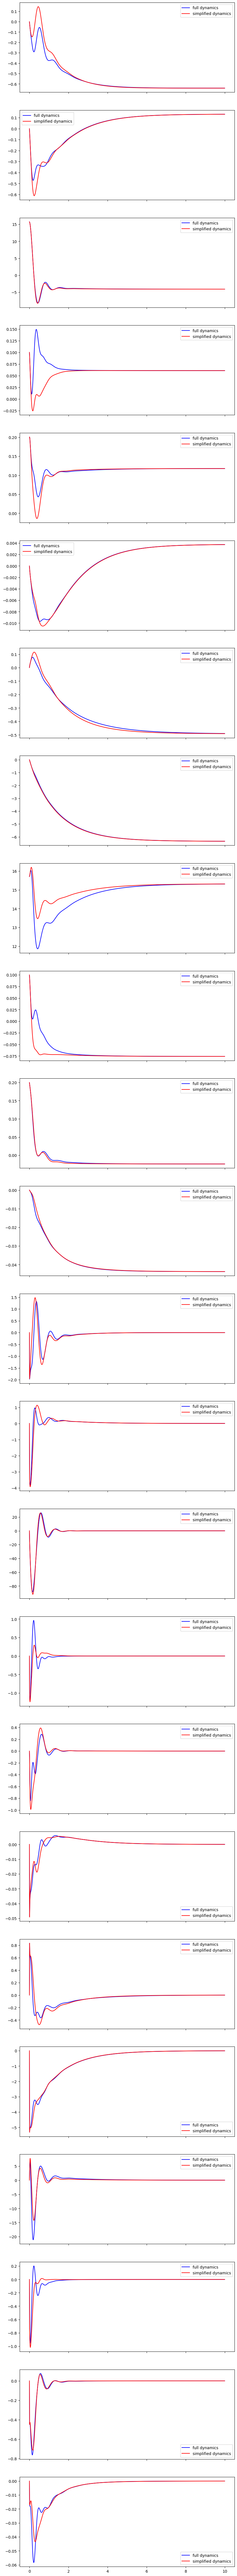

In [12]:
fig, ax = plt.subplots(sim_full.ys.shape[1], 1, figsize=(10, 5*sim_full.ys.shape[1]), sharex=True)
for i in range(sim_full.ys.shape[1]):
    ax[i].plot(sim_full.ts, sim_full.ys[:, i], c='b', label="full dynamics")
    ax[i].plot(sim_simplified.ts, sim_simplified.ys[:, i], c='r', label="simplified dynamics")
    ax[i].legend()
plt.show()